## **SEMANTIC SEGMENTATION OF WASTE IMAGES USING U-NET MODEL**

In [1]:
#The dataset is stored in Google Drive so we need to write this code to access the contents of Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing U-Net Models with ResNet backbones ResNet 18, ResNet 34 and ResNet 50

In [2]:
!pip install segmentation-models
#Segmentation models includes python packages with popular neural network architectures

import tensorflow as tf
import segmentation_models as sm
sm.set_framework('tf.keras')

BACKBONE34='resnet34'
preprocess_input34=sm.get_preprocessing(BACKBONE34)

BACKBONE18='resnet18'
preprocess_input18=sm.get_preprocessing(BACKBONE18)

BACKBONE50='resnet50'
preprocess_input50=sm.get_preprocessing(BACKBONE50)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.4 MB/s 
Segmentation Models: using `keras` framework.


In [3]:
#Essential python modules needed for the project
import random
import numpy as np
import os
import cv2
import glob
from PIL import Image
import matplotlib.pyplot as plt

# Accessing the Images in Dataset

In [4]:
input_dir = "/content/drive/MyDrive/mju-waste-v1.0/JPEGImages"
target_dir = "/content/drive/MyDrive/mju-waste-v1.0/SegmentationClass"

num_classes = 3
batch_size = 32

input_image_paths =sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
input_mask_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_image_paths))


for input_path, target_path in zip(input_image_paths[:6], input_mask_paths[:6]):
    print(input_path, "|", target_path)


Number of samples: 2475
/content/drive/MyDrive/mju-waste-v1.0/JPEGImages/2019-09-19_16_19_32-29_color.png | /content/drive/MyDrive/mju-waste-v1.0/SegmentationClass/2019-09-19_16_19_32-29_color.png
/content/drive/MyDrive/mju-waste-v1.0/JPEGImages/2019-09-19_16_19_44-93_color.png | /content/drive/MyDrive/mju-waste-v1.0/SegmentationClass/2019-09-19_16_19_44-93_color.png
/content/drive/MyDrive/mju-waste-v1.0/JPEGImages/2019-09-19_16_19_49-57_color.png | /content/drive/MyDrive/mju-waste-v1.0/SegmentationClass/2019-09-19_16_19_49-57_color.png
/content/drive/MyDrive/mju-waste-v1.0/JPEGImages/2019-09-19_16_19_55-63_color.png | /content/drive/MyDrive/mju-waste-v1.0/SegmentationClass/2019-09-19_16_19_55-63_color.png
/content/drive/MyDrive/mju-waste-v1.0/JPEGImages/2019-09-19_16_20_00-38_color.png | /content/drive/MyDrive/mju-waste-v1.0/SegmentationClass/2019-09-19_16_20_00-38_color.png
/content/drive/MyDrive/mju-waste-v1.0/JPEGImages/2019-09-19_16_20_06-93_color.png | /content/drive/MyDrive/mju-

# Resizing And Converting Images and Mask to Numpy Array

In [5]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 
#Resize images (height  = X, width = Y)
SIZE_Y = 128
#Capture training image info as a list
train_images = []
I=glob.glob("/content/drive/MyDrive/mju-waste-v1.0/JPEGImages/*.png")
I.sort()
M=glob.glob("/content/drive/MyDrive/mju-waste-v1.0/SegmentationClass/*.png")
M.sort()
for img_path in I:
  #print(img_path)
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  train_images.append(img)

#train_labels.append(label)
#Convert list to array for machine learning processing        

train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = [] 

for mask_path in M:
  mask = cv2.imread(mask_path, 0)       
  mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
  #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
  train_masks.append(mask)
  #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

# Visualizing Waste Object Image with it's corresponding mask

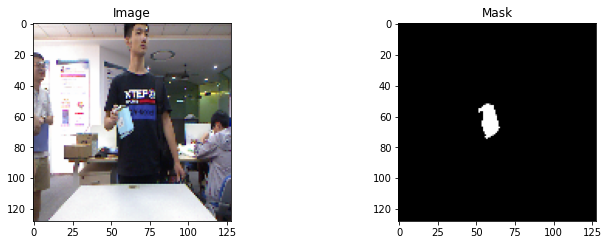

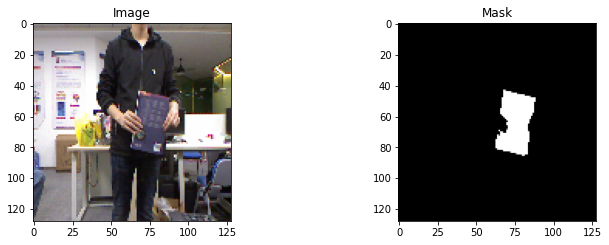

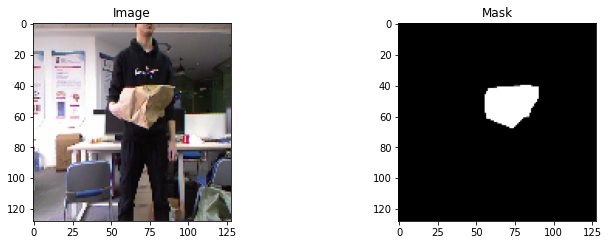

In [6]:
import random 
for i in range(3):
  img_number = random.randint(0, len(train_images)) 
  img = train_images[img_number] 
  mask = train_masks[img_number] 
  plt.figure(figsize=(12, 8))
  plt.subplot(221) 
  plt.title('Image') 
  plt.imshow(img) 
  plt.subplot(222) 
  plt.title('Mask') 
  plt.imshow(mask, cmap="gray") 
  plt.show()

# Splitting dataset into training and testing set

In [7]:
#Use customary x_train and y_train variables

X = train_images[:2400]
Y = train_masks[:2400]
Y = np.expand_dims(Y, axis=3) 

#May not be necessary.. leftover from previous code 

from sklearn.model_selection import train_test_split

x_train18, x_val18, y_train18, y_val18 = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train34, x_val34, y_train34, y_val34 = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train50, x_val50, y_train50, y_val50 = train_test_split(X, Y, test_size=0.2, random_state=42)

# preprocess input
x_train18 = preprocess_input18(x_train18)
x_val18 = preprocess_input18(x_val18)
x_train34 = preprocess_input34(x_train34)
x_val34 = preprocess_input34(x_val34)
x_train50 = preprocess_input50(x_train50)
x_val50 = preprocess_input50(x_val50)

## Checking the shape and type of training and test dataset to prevent anomaly when provided to the U-Net Model

In [8]:
print(x_train18.shape,y_train18.shape)
print(x_val18.shape,y_val18.shape)
print(x_train18.dtype,y_train18.dtype)
print(x_val18.dtype,y_val18.dtype)

print(x_train34.shape,y_train34.shape)
print(x_val34.shape,y_val34.shape)
print(x_train34.dtype,y_train34.dtype)
print(x_val34.dtype,y_val34.dtype)

print(x_train50.shape,y_train50.shape)
print(x_val50.shape,y_val50.shape)
print(x_train50.dtype,y_train50.dtype)
print(x_val50.dtype,y_val50.dtype)


(1920, 128, 128, 3) (1920, 128, 128, 1)
(480, 128, 128, 3) (480, 128, 128, 1)
uint8 uint8
uint8 uint8
(1920, 128, 128, 3) (1920, 128, 128, 1)
(480, 128, 128, 3) (480, 128, 128, 1)
uint8 uint8
uint8 uint8
(1920, 128, 128, 3) (1920, 128, 128, 1)
(480, 128, 128, 3) (480, 128, 128, 1)
uint8 uint8
uint8 uint8


## Converting Dataset From uint8 to float64

In [9]:
x_train18 = x_train18.astype(np.float)
x_val18 = x_val18.astype(np.float)
y_train18 = y_train18.astype(np.float)
y_val18 = y_val18.astype(np.float)

x_train34 = x_train34.astype(np.float)
x_val34 = x_val34.astype(np.float)
y_train34 = y_train34.astype(np.float)
y_val34 = y_val34.astype(np.float)

x_train50 = x_train50.astype(np.float)
x_val50 = x_val50.astype(np.float)
y_train50 = y_train50.astype(np.float)
y_val50= y_val50.astype(np.float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: Depreca

# Loading U-Net Models with different Backbones and Setting the loss function and evaluation metrics

In [10]:
# define model
model18 = sm.Unet(BACKBONE18, encoder_weights='imagenet')
model18.compile('Adam',loss=sm.losses.bce_jaccard_loss, 
              metrics=[sm.metrics.iou_score,sm.metrics.f1_score,
                       sm.metrics.precision,sm.metrics.recall,'accuracy'])

model34 = sm.Unet(BACKBONE34, encoder_weights='imagenet')
model34.compile('Adam',loss=sm.losses.bce_jaccard_loss, 
              metrics=[sm.metrics.iou_score,sm.metrics.f1_score,
                       sm.metrics.precision,sm.metrics.recall,'accuracy'])

model50 = sm.Unet(BACKBONE50, encoder_weights='imagenet')
model50.compile('Adam',loss=sm.losses.bce_jaccard_loss, 
              metrics=[sm.metrics.iou_score,sm.metrics.f1_score,
                       sm.metrics.precision,sm.metrics.recall,'accuracy'])

94592056/94592056 [==============================] - 2s 0us/step


# Training U-Net with ResNet 18 backbone for 10 epochs

In [11]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
h18=model18.fit(
   x=x_train18,
   y=y_train18,
   batch_size=32,
   epochs=10,
   verbose=1,
   validation_data=(x_val18, y_val18),
)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
60/60 [==============================] - 23s 205ms/step - loss: -21.7344 - iou_score: 2.5601 - f1-score: 1.3556 - precision: 2.8789 - recall: 0.9444 - accuracy: 0.8383 - val_loss: -129.6486 - val_iou_score: 1.0800 - val_f1-score: 1.0260 - val_precision: 1.1192 - val_recall: 0.9698 - val_accuracy: 0.4006
Epoch 2/10
60/60 [==============================] - 12s 201ms/step - loss: -62.8568 - iou_score: 8.3055 - f1-score: 1.7704 - precision: 10.9095 - recall: 0.9704 - accuracy: 0.9488 - val_loss: -178.1140 - val_iou_score: 1.0858 - val_f1-score: 1.0318 - val_precision: 1.1447 - val_recall: 0.9617 - val_accuracy: 0.4472
Epoch 3/10
60/60 [==============================] - 12s 205ms/step - loss: -106.7028 - iou_score: 11.4970 - f1-score: 1.8285 - precision: 15.5929 - recall: 0.9734 - accuracy: 0.9567 - val_loss: -103.8617 - val_iou_score: 4.1268 - val_f1-score: 1.5982 - val_precision: 10.9446 - val_recall: 0.8641 - val_accuracy: 0.9652
Epoch 4/10
60/60 [=============================

# Training U-Net with ResNet 34 backbone for 10 epochs

In [12]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
h34=model34.fit(
   x=x_train34,
   y=y_train34,
   batch_size=32,
   epochs=10,
   verbose=1,
   validation_data=(x_val34, y_val34),
)


Epoch 1/10
60/60 [==============================] - 16s 268ms/step - loss: -17.5219 - iou_score: 1.9242 - f1-score: 1.2818 - precision: 2.0854 - recall: 0.9482 - accuracy: 0.8473 - val_loss: -108.2111 - val_iou_score: 0.7839 - val_f1-score: 0.8666 - val_precision: 0.7861 - val_recall: 0.9970 - val_accuracy: 0.0244
Epoch 2/10
60/60 [==============================] - 16s 268ms/step - loss: -56.6667 - iou_score: 6.8407 - f1-score: 1.7179 - precision: 8.5592 - recall: 0.9712 - accuracy: 0.9485 - val_loss: -113.3378 - val_iou_score: 2.5589 - val_f1-score: 1.4295 - val_precision: 3.4303 - val_recall: 0.9136 - val_accuracy: 0.8988
Epoch 3/10
60/60 [==============================] - 17s 285ms/step - loss: -101.3811 - iou_score: 11.2845 - f1-score: 1.8251 - precision: 15.5010 - recall: 0.9718 - accuracy: 0.9581 - val_loss: -263.3203 - val_iou_score: 4.2757 - val_f1-score: 1.6167 - val_precision: 5.7609 - val_recall: 0.9473 - val_accuracy: 0.9049
Epoch 4/10
60/60 [==============================]

# Training U-Net with ResNet 50 backbone for 10 epochs

In [13]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
h50=model50.fit(
   x=x_train50,
   y=y_train50,
   batch_size=32,
   epochs=10,
   verbose=1,
   validation_data=(x_val50, y_val50),
)

Epoch 1/10
60/60 [==============================] - 21s 330ms/step - loss: -12.7461 - iou_score: 2.3018 - f1-score: 1.3109 - precision: 2.6593 - recall: 0.9308 - accuracy: 0.8566 - val_loss: -70.3257 - val_iou_score: 1.4608 - val_f1-score: 1.1764 - val_precision: 1.6918 - val_recall: 0.9184 - val_accuracy: 0.6839
Epoch 2/10
60/60 [==============================] - 21s 344ms/step - loss: -45.0134 - iou_score: 8.1831 - f1-score: 1.7643 - precision: 11.0626 - recall: 0.9670 - accuracy: 0.9470 - val_loss: -18.3645 - val_iou_score: 0.7195 - val_f1-score: 0.8279 - val_precision: 1.0121 - val_recall: 0.7170 - val_accuracy: 0.5021
Epoch 3/10
60/60 [==============================] - 21s 346ms/step - loss: -79.6437 - iou_score: 11.2693 - f1-score: 1.8248 - precision: 15.3442 - recall: 0.9720 - accuracy: 0.9551 - val_loss: -112.8018 - val_iou_score: 1.2581 - val_f1-score: 1.1000 - val_precision: 1.3137 - val_recall: 0.9654 - val_accuracy: 0.4774
Epoch 4/10
60/60 [==============================] -

#Plotting the curves for evaluating the different backbones of U-Net

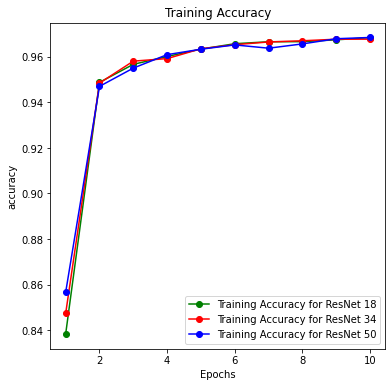

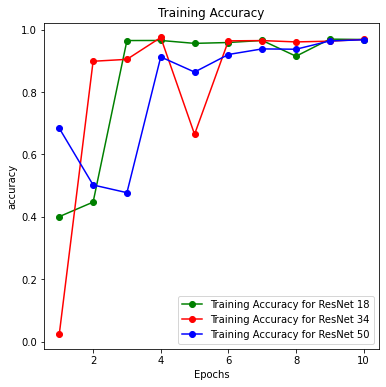

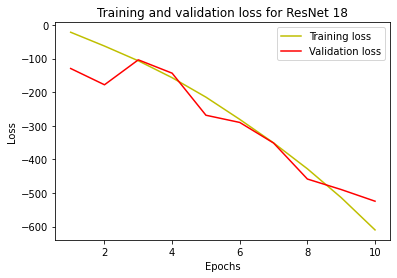

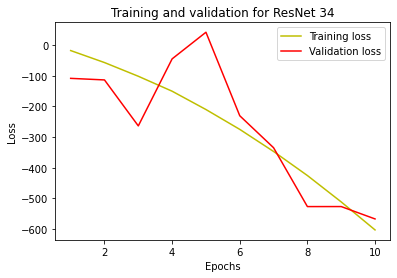

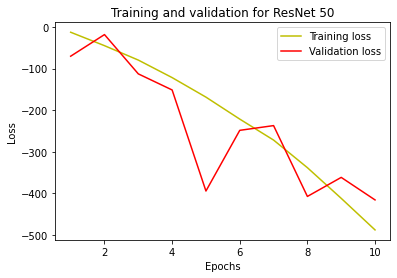

In [14]:
acc18=h18.history['accuracy']
acc34=h34.history['accuracy']
acc50=h50.history['accuracy']

epochs=range(1,len(acc18)+1)
plt.figure(figsize=(6,6))
plt.plot(epochs,acc18,'y', marker="o", label="Training Accuracy for ResNet 18",color="green")
plt.plot(epochs,acc34,'y',marker="o",label="Training Accuracy for ResNet 34",color="red")
plt.plot(epochs,acc50,'y',marker="o",label="Training Accuracy for ResNet 50",color="blue")

plt.title("Training Accuracy")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

acc18=h18.history['val_accuracy']
acc34=h34.history['val_accuracy']
acc50=h50.history['val_accuracy']

epochs=range(1,len(acc18)+1)
plt.figure(figsize=(6,6))
plt.plot(epochs,acc18,'y', marker="o", label="Training Accuracy for ResNet 18",color="green")
plt.plot(epochs,acc34,'y',marker="o",label="Training Accuracy for ResNet 34",color="red")
plt.plot(epochs,acc50,'y',marker="o",label="Training Accuracy for ResNet 50",color="blue")

plt.title("Training Accuracy")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


loss=h18.history['loss']
val_loss=h18.history['val_loss']
epochs=range(1,len(loss)+1)
epochs=np.linspace(1,10,10)
plt.plot(epochs,loss,'y',label="Training loss")
plt.plot(epochs,val_loss,'r',label="Validation loss")
plt.title("Training and validation loss for ResNet 18")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss=h34.history['loss']
val_loss=h34.history['val_loss']
epochs=range(1,len(loss)+1)
epochs=np.linspace(1,10,10)
plt.plot(epochs,loss,'y',label="Training loss")
plt.plot(epochs,val_loss,'r',label="Validation loss")
plt.title("Training and validation for ResNet 34")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss=h50.history['loss']
val_loss=h50.history['val_loss']
epochs=range(1,len(loss)+1)
plt.plot(epochs,loss,'y',label="Training loss")
plt.plot(epochs,val_loss,'r',label="Validation loss")
plt.title("Training and validation for ResNet 50")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


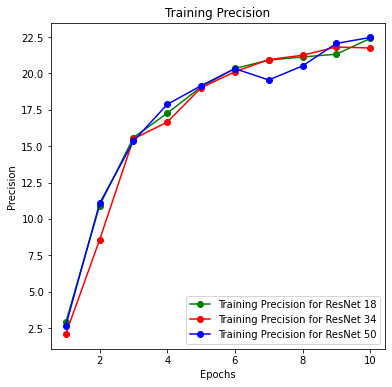

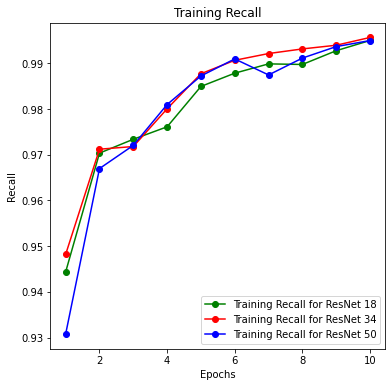

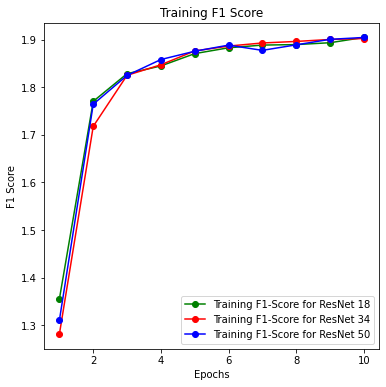

In [15]:
acc18=h18.history['precision']
acc34=h34.history['precision']
acc50=h50.history['precision']

epochs=range(1,len(acc18)+1)
plt.figure(figsize=(6,6))
plt.plot(epochs,acc18,'y',marker="o",label="Training Precision for ResNet 18",color="green")
plt.plot(epochs,acc34,'y',marker="o",label="Training Precision for ResNet 34",color="red")
plt.plot(epochs,acc50,'y',marker="o",label="Training Precision for ResNet 50",color="blue")

plt.title("Training Precision")
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()


acc18=h18.history['recall']
acc34=h34.history['recall']
acc50=h50.history['recall']

epochs=range(1,len(acc18)+1)
plt.figure(figsize=(6,6))
plt.plot(epochs,acc18,'y',marker="o",label="Training Recall for ResNet 18",color="green")
plt.plot(epochs,acc34,'y',marker="o",label="Training Recall for ResNet 34",color="red")
plt.plot(epochs,acc50,'y',marker="o",label="Training Recall for ResNet 50",color="blue")

plt.title("Training Recall")
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

acc18=h18.history['f1-score']
acc34=h34.history['f1-score']
acc50=h50.history['f1-score']

epochs=range(1,len(acc18)+1)
plt.figure(figsize=(6,6))
plt.plot(epochs,acc18,'y',marker="o",label="Training F1-Score for ResNet 18",color="green")
plt.plot(epochs,acc34,'y',marker="o",label="Training F1-Score for ResNet 34",color="red")
plt.plot(epochs,acc50,'y',marker="o",label="Training F1-Score for ResNet 50",color="blue")

plt.title("Training F1 Score")
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

## Checking IoU Scores

In [16]:

y_pred18=model18.predict(x_val18)
y_pred_thresholded = y_pred18 > 0.5
intersection1 = np.logical_and(y_val18, y_pred_thresholded)
union1 = np.logical_or(y_val18, y_pred_thresholded)
iou_score = np.sum(intersection1) / np.sum(union1)
print("IoU socre for ResNet 18 backbone: ", iou_score)
y_pred34=model34.predict(x_val34)
y_pred_thresholded = y_pred34 > 0.5
intersection2 = np.logical_and(y_val34, y_pred_thresholded)
union2 = np.logical_or(y_val34, y_pred_thresholded)
iou_score = np.sum(intersection2) / np.sum(union2)
print("IoU socre for ResNet 34 backbone: ", iou_score)

y_pred50=model50.predict(x_val50)
y_pred_thresholded = y_pred50> 0.5
intersection3 = np.logical_and(y_val50, y_pred_thresholded)
union3 = np.logical_or(y_val50, y_pred_thresholded)
iou_score = np.sum(intersection3) / np.sum(union3)
print("IoU socre for ResNet 50 backbone: ", iou_score)

 2/15 [===>..........................] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


15/15 [==============================] - 1s 54ms/step
IoU socre for ResNet 18 backbone:  0.5849578120453884
15/15 [==============================] - 1s 78ms/step
IoU socre for ResNet 34 backbone:  0.5822125248314717
15/15 [==============================] - 1s 86ms/step
IoU socre for ResNet 50 backbone:  0.5597588432678393


## Saving the trained models as h5 file

In [17]:
model18.save('/content/drive/MyDrive/modelv3Resnet18.h5')
model34.save('/content/drive/MyDrive/modelv3Resnet34.h5')
model50.save('/content/drive/MyDrive/modelv3Resnet50.h5')

## Loading the trained models

In [20]:
from tensorflow import keras
model18=keras.models.load_model('/content/drive/MyDrive/modelv3Resnet18.h5',compile=False)
model34=keras.models.load_model('/content/drive/MyDrive/modelv3Resnet34.h5',compile=False)
model50=keras.models.load_model('/content/drive/MyDrive/modelv3Resnet50.h5',compile=False)


## Testing the three models on certain images of dataset that were not used for training the models

1/1 [==============================] - 0s 95ms/step


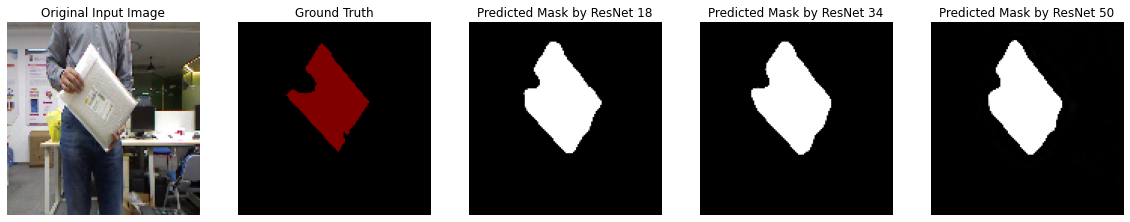

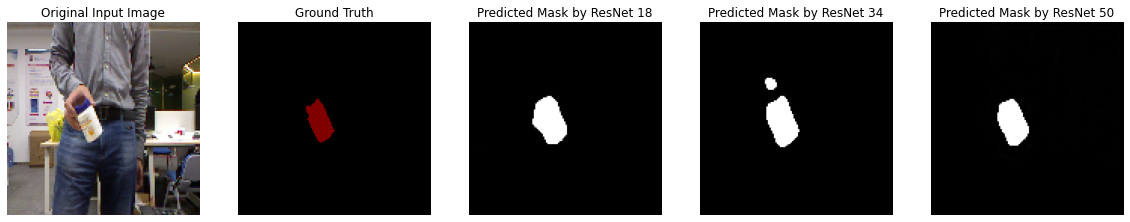

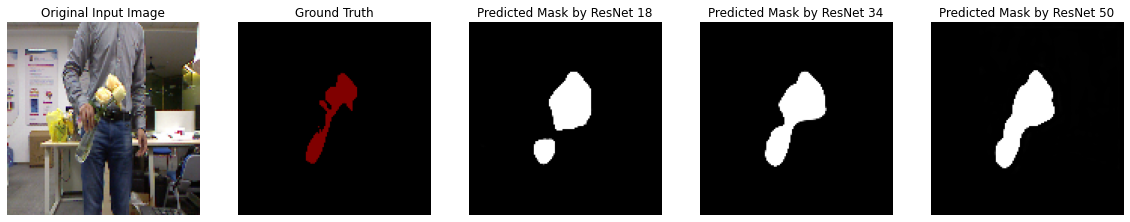

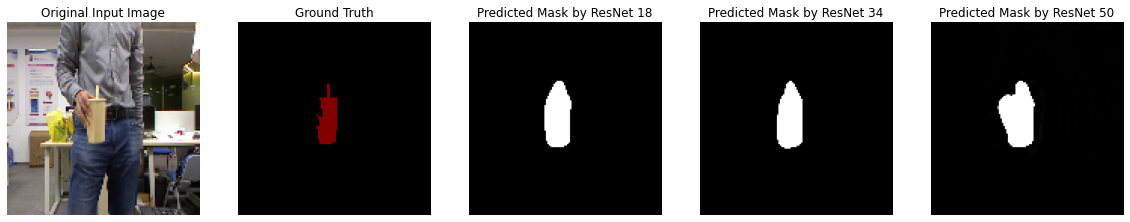

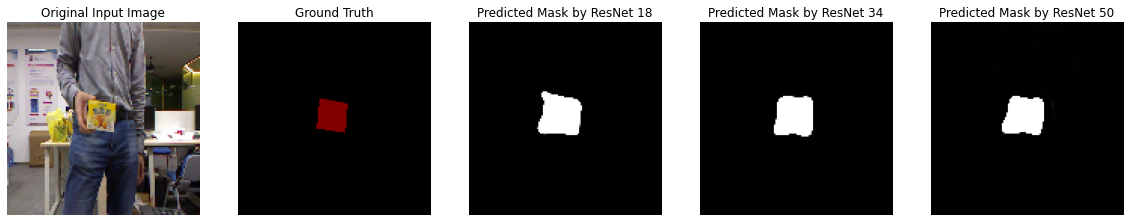

In [21]:
#Test on a different images from 2400 till 2475 
for i in range(5):
  i=random.randint(2400,2476)
  fig, axes = plt.subplots(1,5, figsize=(20,20))
  ax = axes.flatten()
  k=0
  x=input_image_paths[i]
  test_img = cv2.imread(x, cv2.IMREAD_COLOR)       
  test_img = cv2.resize(test_img, (128,128))
  test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)

  ax[k].imshow(test_img)
  ax[k].set_axis_off()
  ax[k].set_title("Original Input Image", fontsize=12)

  test_img = np.expand_dims(test_img, axis=0)

  y=input_mask_paths[i]
  test_img2 = cv2.imread(y, cv2.IMREAD_COLOR)       
  test_img2 = cv2.resize(test_img2, (128,128))
  test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_RGB2BGR)

  ax[k+1].imshow(test_img2, cmap="gray")
  ax[k+1].set_axis_off()
  ax[k+1].set_title("Ground Truth", fontsize=12)

  prediction18 = model18.predict(test_img)
  prediction34 = model34.predict(test_img)
  prediction50 = model50.predict(test_img)

  #View segmented image
  prediction_image = prediction18.reshape(128,128)
  ax[k+2].imshow(prediction_image, cmap='gray')
  ax[k+2].set_axis_off()
  ax[k+2].set_title("Predicted Mask by ResNet 18", fontsize=12)

  #View segmented image
  prediction_image2 = prediction34.reshape(128,128)
  ax[k+3].imshow(prediction_image2, cmap='gray')
  ax[k+3].set_axis_off()
  ax[k+3].set_title("Predicted Mask by ResNet 34", fontsize=12)

  #View segmented image
  prediction_image3 = prediction50.reshape(128,128)
  ax[k+4].imshow(prediction_image3, cmap='gray')
  ax[k+4].set_axis_off()
  ax[k+4].set_title("Predicted Mask by ResNet 50", fontsize=12)
  k+=1